In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import scipy
import requests
import tarfile

from tqdm import tqdm
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Downloading and creating a custom dataset

In [2]:
root_dir = "/kaggle/working/flower_data"

In [3]:
def download_dataset():
    os.makedirs("flower_data", exist_ok=True)

    print("Started downloading flower images")
    image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    response = requests.get(image_url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    
    img_folder_path = os.path.join(root_dir, 'jpg')
    labels_file_path = os.path.join(root_dir, 'imagelabels.mat')
    tgz_path = os.path.join(root_dir, '102flowers.tgz')
    
    with open(tgz_path, "wb") as file:
        for data in tqdm(
            response.iter_content(chunk_size=1024),
            total=total_size // 1024,
        ):
            file.write(data)

    print("Finished downloading flower images")
    
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(root_dir)

    print("Started downloading flower images")
    labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
    response = requests.get(labels_url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(labels_file_path, "wb") as file:
        for data in tqdm(
            response.iter_content(chunk_size=1024),
            total=total_size // 1024,
        ):
            file.write(data)

    print("Finished downloading flower images")

In [4]:
download_dataset()

Started downloading flower images


336780it [00:31, 10734.63it/s]                            


Finished downloading flower images
Started downloading flower images


1it [00:00, 6297.75it/s]

Finished downloading flower images


In [5]:
class OxfordFlowersDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, "jpg")
        
        labels_mat = scipy.io.loadmat(os.path.join(root_dir, "imagelabels.mat"))
        self.labels = labels_mat["labels"][0] - 1

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name = f"image_{idx+1:05d}.jpg"
        image_path = os.path.join(self.img_dir, image_name)
        image = Image.open(image_path)
        label = self.labels[idx]

        return image, label

In [6]:
dataset = OxfordFlowersDataset(root_dir)
img, label = dataset[0]
img, label

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=591x500>, 76)

<function matplotlib.pyplot.show(close=None, block=None)>

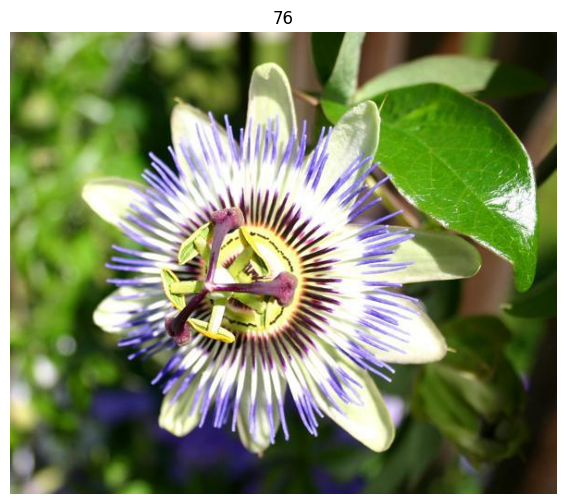

In [7]:
plt.figure(figsize=(8, 6))
plt.title(label)
plt.imshow(np.array(img))
plt.axis("off")
plt.show

## Data Quality: Handling different sizes and formats

Data size mistmatch:
- Using `transforms.resize((224, 224))` will resize to a fixed size but it won't keep the same image ratio.
- Better to use one value to respect the ratio: `transforms.resize(256)`
- Then, we can crop it to the size of 224 (square)

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
class OxfordFlowersDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, "jpg")
        self.transform = transform
        
        labels_mat = scipy.io.loadmat(os.path.join(root_dir, "imagelabels.mat"))
        self.labels = labels_mat["labels"][0] - 1

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name = f"image_{idx+1:05d}.jpg"
        image_path = os.path.join(self.img_dir, image_name)
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
dataset = OxfordFlowersDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"Success! Batch Shape: {images.shape}")
    break

Success! Batch Shape: torch.Size([4, 3, 224, 224])


Debugging each dataset transform

In [11]:
raw_dataset = OxfordFlowersDataset(root_dir)
image, label = raw_dataset[0]

print(f"Raw image: {image.size}")
image = transforms.Resize(256)(image)
print(f"Resized image: {image.size}")
image = transforms.CenterCrop(224)(image)
print(f"Cropped image: {image.size}")
image = transforms.ToTensor()(image)
print(f"Tensor image: {image.shape}, range[{image.min():.1f}, {image.max():.1f}]")
image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
print(f"Normalized image: {image.shape}, range[{image.min():.1f}, {image.max():.1f}]")

Raw image: (591, 500)
Resized image: (302, 256)
Cropped image: (224, 224)
Tensor image: torch.Size([3, 224, 224]), range[0.0, 1.0]
Normalized image: torch.Size([3, 224, 224]), range[-2.1, 2.6]
